In [23]:
import ultralytics
from ultralytics import YOLO
ultralytics.checks()
import cv2
from matplotlib import pyplot as plt
import numpy as np
import torch
import imutils


Ultralytics 8.3.23  Python-3.10.11 torch-2.5.0+cpu CPU (AMD Ryzen 7 3700U with Radeon Vega Mobile Gfx)
Setup complete  (8 CPUs, 5.9 GB RAM, 456.9/476.1 GB disk)


In [24]:
model = YOLO("../models/sudoku_bound_detector_20e.pt",)
model

YOLO(
  (model): SegmentationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_runni

In [25]:
predictions = model.predict(source="../assets/sudoku1.jpg")
# print(model.predict)


image 1/1 c:\Users\ANDER\Documents\Tpicos Selectos en IA\sudoku-solver-topics-final\segmentation\..\assets\sudoku1.jpg: 480x640 1 sudoku, 422.4ms
Speed: 9.1ms preprocess, 422.4ms inference, 22.7ms postprocess per image at shape (1, 3, 480, 640)


In [26]:
print(predictions)

[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: ultralytics.engine.results.Masks object
names: {0: 'sudoku'}
obb: None
orig_img: array([[[131,  59,  17],
        [128,  56,  14],
        [144,  68,  26],
        ...,
        [ 47,  52,  53],
        [ 38,  46,  45],
        [ 41,  49,  48]],

       [[145,  71,  29],
        [134,  60,  18],
        [139,  63,  21],
        ...,
        [ 39,  44,  47],
        [ 38,  46,  46],
        [ 39,  47,  47]],

       [[129,  50,   9],
        [134,  55,  14],
        [142,  62,  21],
        ...,
        [ 41,  44,  52],
        [ 42,  46,  51],
        [ 48,  52,  57]],

       ...,

       [[146,  77,  37],
        [139,  70,  30],
        [138,  69,  29],
        ...,
        [ 99, 110, 102],
        [116, 126, 120],
        [102, 113, 105]],

       [[140,  72,  29],
        [140,  72,  29],
        [142,  74,  31],
        ...,
        [108, 119, 109],
  

In [27]:
print(predictions[0].boxes)

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.9600])
data: tensor([[3.4889e+02, 3.6284e+02, 1.1172e+03, 1.0457e+03, 9.5995e-01, 0.0000e+00]])
id: None
is_track: False
orig_shape: (1200, 1600)
shape: torch.Size([1, 6])
xywh: tensor([[733.0275, 704.2466, 768.2825, 682.8190]])
xywhn: tensor([[0.4581, 0.5869, 0.4802, 0.5690]])
xyxy: tensor([[ 348.8863,  362.8371, 1117.1687, 1045.6561]])
xyxyn: tensor([[0.2181, 0.3024, 0.6982, 0.8714]])


In [28]:
predictions[0].boxes.xyxy

tensor([[ 348.8863,  362.8371, 1117.1687, 1045.6561]])

In [29]:
print(
    torch.tensor(
    [
        [
            int(box[0] - 0.1 * box[0]),
            int(box[1] - 0.1 * box[1]),
            int(box[2] + 0.1 * box[2]),
            int(box[3] + 0.1 * box[3]),
        ]
        for box in predictions[0].boxes.xyxy
    ])
)

tensor([[ 313,  326, 1228, 1150]])


In [30]:
# predictions[0].save_crop(file_name="cropped", save_dir="../assets")

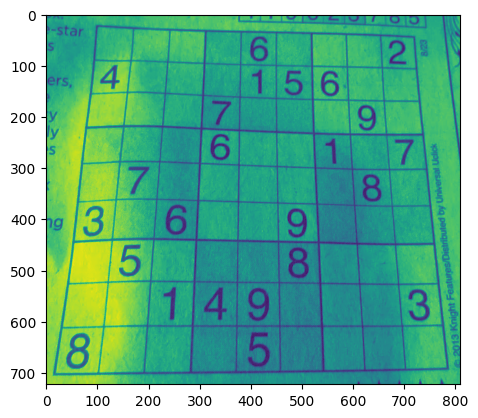

In [31]:
image_total = cv2.imread("../assets/sudoku1.jpg", cv2.IMREAD_GRAYSCALE)
coord_crop = torch.tensor(
    [
        [
            int(box[0] - 20),
            int(box[1] - 20),
            int(box[2] + 20),
            int(box[3] + 20),
        ]
        for box in predictions[0].boxes.xyxy
    ]
)

cropped_image = image_total[
    coord_crop[0][1] : coord_crop[0][3], coord_crop[0][0] : coord_crop[0][2]
]
image = cropped_image
plt.imshow(cropped_image)
plt.show()

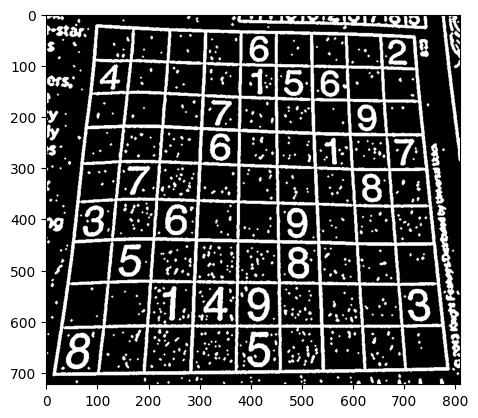

In [55]:
proc = cv2.GaussianBlur(cropped_image.copy(), (9, 9), 0)
# proc = cv2.Canny(proc, 25, 100)
# proc = cv2.medianBlur(cropped_image.copy(), 5)

proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
proc = cv2.bitwise_not(proc, proc)  
# kernel = np.ones((3, 3), np.uint8)
kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]],np.uint8)
proc = cv2.erode(proc, kernel, iterations=1)
proc = cv2.dilate(proc, kernel, iterations=2)
proc = cv2.morphologyEx(proc, cv2.MORPH_CLOSE, kernel)
# proc = cv2.bitwise_not(proc, proc)  

#### CROPPED ####
mask = np.zeros((cropped_image.shape),np.uint8)

plt.imshow(cv2.cvtColor(proc, cv2.COLOR_BGR2RGB))

In [56]:
def order_points_of_quadrilateral(pts):
    """
    Given an array of four points describing a quadrilateral,
    sorts them in the following order:
    (top-left, top-right, bottom-right, bottom-left)
    """
    rect = np.zeros((4, 2), dtype="float32")
    # Summing the x and y coordinates of each point to one value,
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # Computing the difference between the x and y value of each point, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect
def four_point_transform(img, pts):
    """
    Given an array of four points describing a quadrilateral in an
    image, returns a homography matrix that warps this quadrilateral
    into a top-down view
    """
    # Obtain a consistent order of the points and unpack them
    # individually
    rect = order_points_of_quadrilateral(pts)
    (top_left, top_right, bottom_right, bottom_left) = rect

    # Compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(
        ((bottom_right[0] - bottom_left[0]) ** 2)
        + ((bottom_right[1] - bottom_left[1]) ** 2)
    )
    widthB = np.sqrt(
        ((top_right[0] - top_left[0]) ** 2) + ((top_right[1] - top_left[1]) ** 2)
    )
    max_width = min(int(widthA), int(widthB))

    # Compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    height_a = np.sqrt(
        ((top_right[0] - bottom_right[0]) ** 2)
        + ((top_right[1] - bottom_right[1]) ** 2)
    )
    height_b = np.sqrt(
        ((top_left[0] - bottom_left[0]) ** 2) + ((top_left[1] - bottom_left[1]) ** 2)
    )
    max_height = min(int(height_a), int(height_b))

    # Now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array(
        [
            [10, 10],
            [max_width - 10, 10],
            [max_width - 10, max_height - 10],
            [10, max_height - 10],
        ],
        dtype="float32",
    )

    # Compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(img, M, (max_width + 10, max_height + 10))

    return warped, M

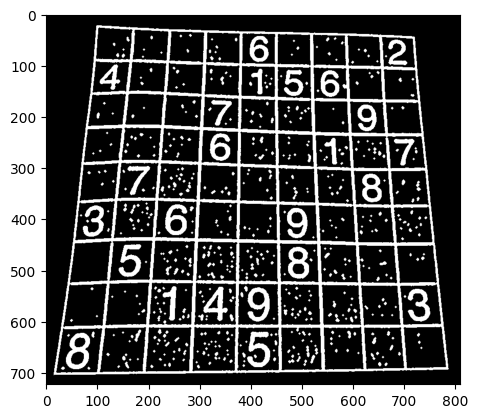

In [57]:
contours = cv2.findContours(proc, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(contours)
# cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:1]
max_area = 0
best_cnt = None

for c in cnts:
    # Approximate the contour in order to determine whether the contour is a quadrilateral

    area = cv2.contourArea(c)

    if area > 1000:
        if area > max_area:
            max_area = area
            best_cnt = c

# peri = cv2.arcLength(best_cnt, True)
# approx = cv2.approxPolyDP(best_cnt, 0.02 * peri, True)

# # We are looking for a contour that is roughly a quadrilateral
# if len(approx) == 4:
#     warped, M = four_point_transform(
#         proc,
#         np.array([approx[0][0], approx[1][0], approx[2][0], approx[3][0]]),
#     )
#     # warped = cv2.dilate(warped, kernel, iterations=2)
#     warped = cv2.bitwise_not(warped, warped)
#     plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
#     plt.show()
#     # break
cv2.drawContours(mask, [best_cnt], 0, 255, -1)
cv2.drawContours(mask, [best_cnt], 0, 0, 2)

warped = cv2.bitwise_and(proc, mask)
# warped = cv2.bitwise_not(warped, warped)
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))

# res = cv2.bitwise_and(proc, mask)
# plt.imshow(res)

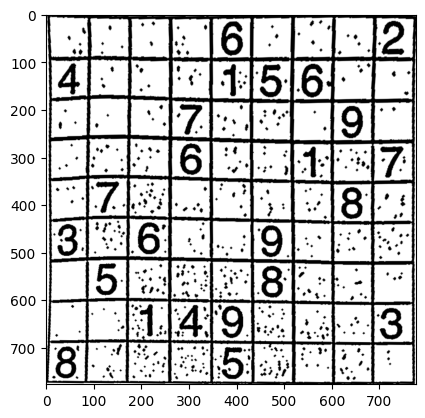

In [58]:
# Get the bounding rectangle of the contour
x, y, w, h = cv2.boundingRect(best_cnt)

# Define the size of the square as the maximum dimension of the bounding box
side_length = max(w, h)

# Approximate the contour to get four corners
epsilon = 0.02 * cv2.arcLength(best_cnt, True)
approx = cv2.approxPolyDP(best_cnt, epsilon, True)

# If the contour does not have exactly 4 corners, use the bounding box corners
if len(approx) != 4:
    src_points = np.array([[x, y], [x + w, y], [x + w, y + h], [x, y + h]], dtype=np.float32)
else:
    # Otherwise, use the 4 approximated corners
    src_points = np.array([point[0] for point in approx], dtype=np.float32)

# Order points in the correct order: top-left, top-right, bottom-right, bottom-left
src_points = src_points[np.argsort(src_points[:, 1])]
if src_points[0][0] > src_points[1][0]:
    src_points[[0, 1]] = src_points[[1, 0]]
if src_points[2][0] < src_points[3][0]:
    src_points[[2, 3]] = src_points[[3, 2]]

# Define destination points for a square
dst_points = np.array([[0, 0], [side_length - 1, 0], 
                       [side_length - 1, side_length - 1], [0, side_length - 1]], dtype=np.float32)

# Compute the perspective transformation matrix
matrix = cv2.getPerspectiveTransform(src_points, dst_points)

# Warp the image to the square output
warped_square = cv2.warpPerspective(warped, matrix, (side_length, side_length))
warped_square = cv2.bitwise_not(warped_square, warped_square)
plt.imshow(cv2.cvtColor(warped_square, cv2.COLOR_BGR2RGB))

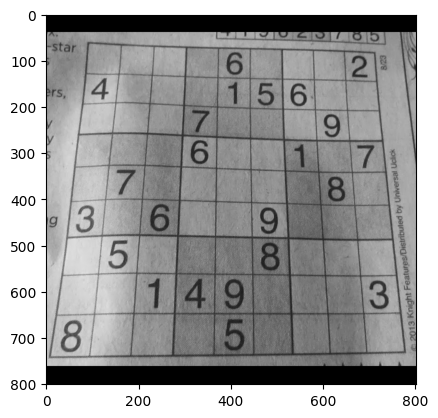

In [36]:
# Step 1: Get the bounding box of the contour
x, y, w, h = cv2.boundingRect(best_cnt)

# Step 2: Extract the region of interest (ROI) from the source image
roi = cropped_image.copy()[y:y+h, x:x+w]

# Step 3: Define the side length of the square as the maximum dimension of the bounding box
side_length = max(w, h)

# Step 4: Create a square canvas with the same number of channels as `src_img`
channels = cropped_image.copy().shape[2] if len(cropped_image.copy().shape) == 3 else 0
square_canvas = np.zeros((side_length, side_length), dtype=np.uint8)

# Step 5: Resize the ROI to fit within the square canvas while preserving the aspect ratio
if w > h:
    new_w = side_length
    new_h = int(h * (side_length / w))
else:
    new_h = side_length
    new_w = int(w * (side_length / h))

resized_roi = cv2.resize(roi, (new_w, new_h))

# Step 6: Center the resized ROI on the square canvas
x_offset = (side_length - new_w) // 2
y_offset = (side_length - new_h) // 2
square_canvas[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized_roi
# Display or save the final square-fitted image
plt.imshow(cv2.cvtColor(square_canvas, cv2.COLOR_BGR2RGB))

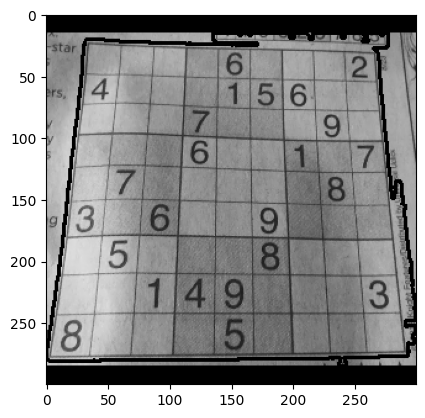

In [37]:

# Step 1: Find the minimum enclosing rectangle for the contour
x, y, w, h = cv2.boundingRect(best_cnt)

# Extract the ROI (Region of Interest) of the contour
roi = cropped_image.copy()[y:y+h, x:x+w]

# Scale factor for width and height to fit within a square
side_length = 300  # Define the side length of the square
scale_w = side_length / w
scale_h = side_length / h
scale = min(scale_w, scale_h)  # Choose the smaller scale to keep the contour inside the square

# Step 2: Resize the ROI with the scale factor while preserving the aspect ratio
new_w = int(w * scale)
new_h = int(h * scale)
resized_roi = cv2.resize(roi, (new_w, new_h))

# Step 3: Create a square canvas with the desired side length
square_canvas = np.zeros((side_length, side_length), dtype=np.uint8)

# Step 4: Center the resized ROI within the square canvas
x_offset = (side_length - new_w) // 2
y_offset = (side_length - new_h) // 2
square_canvas[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized_roi

# Step 5: Adjust the contour points to fit within the square canvas
scaled_cnt = best_cnt - [x, y]  # Shift points to start from (0,0) relative to ROI
scaled_cnt = (scaled_cnt * scale).astype(np.int32)  # Scale points
scaled_cnt += [x_offset, y_offset]  # Center within the square canvas

# Optional: Draw the scaled contour on the canvas for visualization
cv2.drawContours(square_canvas, [scaled_cnt], -1, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(square_canvas, cv2.COLOR_BGR2RGB))

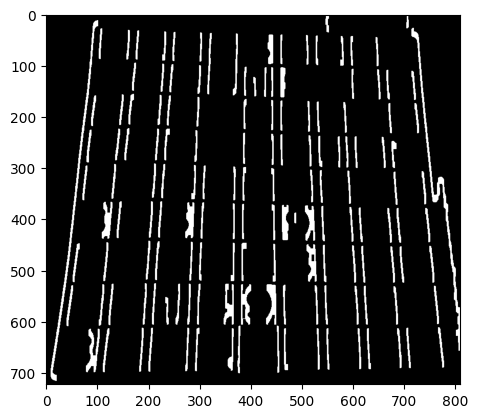

In [38]:
# Finding Vertical Lines

kernelx = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 10))

dx = cv2.Sobel(warped, cv2.CV_16S, 1, 0)
dx = cv2.convertScaleAbs(dx)
cv2.normalize(dx, dx, 0, 255, cv2.NORM_MINMAX)
ret, close = cv2.threshold(dx, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
close = cv2.morphologyEx(close, cv2.MORPH_DILATE, kernelx, iterations=1)

contour, hier = cv2.findContours(close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contour:
    x, y, w, h = cv2.boundingRect(cnt)
    if h / w > 5:
        cv2.drawContours(close, [cnt], 0, 255, -1)
    else:
        cv2.drawContours(close, [cnt], 0, 0, -1)
close = cv2.morphologyEx(close, cv2.MORPH_CLOSE, None, iterations=2)
closex = close.copy()

plt.imshow(cv2.cvtColor(closex, cv2.COLOR_BGR2RGB))

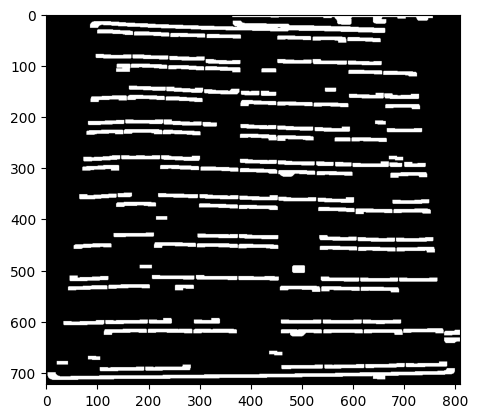

In [39]:
# Finding Horizontal Lines

kernely = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 2))
dy = cv2.Sobel(warped, cv2.CV_16S, 0, 2)
dy = cv2.convertScaleAbs(dy)
cv2.normalize(dy, dy, 0, 255, cv2.NORM_MINMAX)
ret, close = cv2.threshold(dy, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
close = cv2.morphologyEx(close, cv2.MORPH_DILATE, kernely)

contour, hier = cv2.findContours(close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contour:
    x, y, w, h = cv2.boundingRect(cnt)
    if w / h > 4:
        cv2.drawContours(close, [cnt], 0, 255, -1)
    else:
        cv2.drawContours(close, [cnt], 0, 0, -1)

close = cv2.morphologyEx(close, cv2.MORPH_DILATE, None, iterations=2)
closey = close.copy()

plt.imshow(cv2.cvtColor(closey, cv2.COLOR_BGR2RGB))

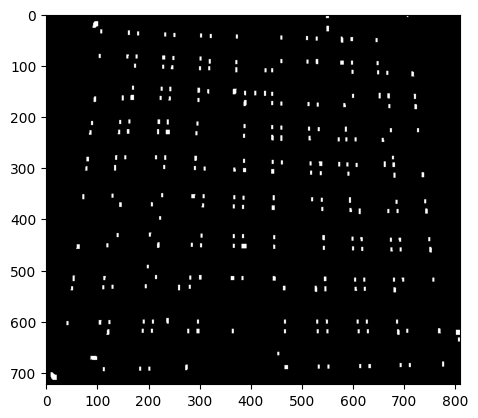

In [40]:
intersect = cv2.bitwise_and(closex,closey)
plt.imshow(cv2.cvtColor(intersect, cv2.COLOR_BGR2RGB))

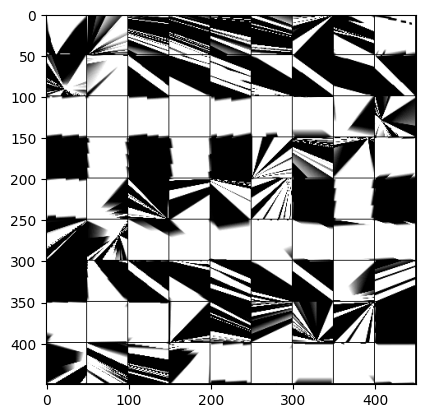

In [41]:
# Correcting defects

contour, hier = cv2.findContours(
    intersect.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE
)
centroids = []
copy_cropped = image.copy()
plt.imshow(copy_cropped)
for cnt in contour:
    mom = cv2.moments(cnt)
    (x, y) = int(mom["m10"] / (mom["m00"] + 0.00000001)), int(mom["m01"] / (mom["m00"] + 0.00000001))
    cv2.circle(copy_cropped, (x, y), 4, (0, 255, 0), -1)
    centroids.append((x, y))

plt.imshow(cv2.cvtColor(copy_cropped, cv2.COLOR_BGR2RGB))

centroids = np.array(centroids, dtype=np.float32)
c = centroids.reshape((len(centroids), 2))
c2 = c[np.argsort(c[:, 1])]


b = np.vstack(
    [
        c2[i * 10 : (i + 1) * 10][np.argsort(c2[i * 10 : (i + 1) * 10, 0])]
        for i in range(10)
    ]
)
bm = b.reshape((10, 10, 2))
# plt.imshow(cv2.cvtColor(copy_cropped, cv2.COLOR_BGR2RGB))
output = np.zeros((450, 450, 3), np.uint8)
for i, j in enumerate(b):
    ri = i // 10
    ci = i % 10
    if ci != 9 and ri != 9:
        src = bm[ri : (ri + 2), ci : (ci + 2), :].reshape((4, 2)) # TypeError: slice indices must be integers or None or have an __index__ method
        dst = np.array(
            [
                [ci * 50, ri * 50],
                [(ci + 1) * 50 - 1, ri * 50],
                [ci * 50, (ri + 1) * 50 - 1],
                [(ci + 1) * 50 - 1, (ri + 1) * 50 - 1],
            ],
            np.float32,
        )
        retval = cv2.getPerspectiveTransform(src, dst)
        warp = cv2.warpPerspective(warped, retval, (450, 450))
        if len(warp.shape) == 2:  # Grayscale image with shape (49, 49)
            warp = cv2.cvtColor(warp, cv2.COLOR_GRAY2BGR)  # Convert to (49, 49, 3)
        output[ri * 50 : (ri + 1) * 50 - 1, ci * 50 : (ci + 1) * 50 - 1] = warp[ri * 50 : (ri + 1) * 50 - 1, ci * 50 : (ci + 1) * 50 - 1].copy()

plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))